In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import os, glob, csv
from datetime import date, datetime
from dateutil.parser import parse

In [2]:
def dedup_set_index(masterdf):
    '''
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Ensures each row is a unique course
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    ID_isdigit = masterdf.ID.apply(lambda x:str(x).isdigit())
    masterdf.loc[ID_isdigit,'ID']= masterdf[ID_isdigit]['ID']+'_'+masterdf[ID_isdigit].index.map(lambda x:str(x))
    masterdf.drop_duplicates('ID',keep='last', inplace=True)
    masterdf.set_index('ID', verify_integrity=True)
    return masterdf

In [3]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Prep masterdf
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

happiness_coursetypes = ['3 Days YES!+','Part I Course', '3 Days Part I Course', 
                         'Happiness Program', 'Happiness Program (3 Days)','Happiness Program For Youth', 'YES!+']

parse_dates = ['Start Date', 'End Date', 'Created Date', 'CRF Submitted Date'] 
masterdf = pd.read_csv(os.getcwd()+'/../CRMAutomation/masterdata.csv', parse_dates=parse_dates) 
masterdf = dedup_set_index(masterdf)

masterdf['index_orig'] = masterdf.index

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def teachers2dict(row):
    '''
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Splits 'Teachers' string into a list of dictionaries
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    returnlist = []
#     try:
    teacher_row  =row['Teachers']
    teacher_row = teacher_row.replace('Pallavi Kamalapurkar ,(KR1238)','Pallavi Kamalapurkar(KR1238)')
    teacher_row = teacher_row.replace('Poonam S, Bandawar(AP0673)','Poonam S Bandawar(AP0673)')
#     teacher_row = teacher_row.replace('Ashram_coordinator@vvki.net()', 'Ashram_coordinator@vvki.net(XX0000)')
    teacherlist = teacher_row.split(',')
    for teacher in teacherlist:
        teacherdict = {}
        teacherid = teacher.split('(')[-1].split(')')[0].strip()
        teachername =teacher.split('(')[0].strip()
        
        if not ((not teacherid[:2].isdigit()) and (teacherid[-4:].isdigit())):
            if 'Ashram_coordinator@vvki.net()' not in teacher_row:
                raise ValueError('improper format for teacherId: {0}; teacher_row: {1}'.format(teacherid, teacher_row))
        elif ',' in teachername or ',' in teacherid:
            raise ValueError('teachername (0} has a comma in it'.format(teachername))
        
        teacherdict['Name'] = teachername
        teacherdict['Id'] = teacherid
        returnlist.append(teacherdict)
#     except:
#         print row['Teachers']
    return returnlist

In [5]:
'''
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Create a temp dataframe so that original index
is preserved: teachers_column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''
teachers_column = masterdf.loc[:,['index_orig','Teachers']]
teachers_column.dropna(subset=['Teachers'], inplace=True)
teachers_column['teacher_rowdicts'] = teachers_column.apply(teachers2dict, axis=1)
teachers_column
teachers_column.set_index('index_orig', inplace=True)

In [6]:
'''
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
masterdf2 = masterdf without the row with empty 'Teachers'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''

masterdf['teacher_rowdicts'] = teachers_column['teacher_rowdicts']
masterdf2 = masterdf.dropna(subset=['Teachers'])

In [7]:
'''
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
list of dictionaries, each with a single teacher
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''
teacher_dictlist_hp = []
teacher_dictlist = []
for (index, row) in masterdf2.iterrows():
    rowdict = row['teacher_rowdicts']
    [teacher_dictlist.append(teacher) for teacher in rowdict]
    if row['Course Type'] in happiness_coursetypes:
        [teacher_dictlist_hp.append(teacher) for teacher in rowdict]

In [8]:
'''
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Convert list of dictionaries to dataframe to de-dup
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''


teacher_df = DataFrame(teacher_dictlist)
teacher_df.drop_duplicates('Id', inplace=True)
teacher_df.head()

Id            Name
0  KR0305      Mallika K.
1  KR0067     Pramila Rao
2  KR0077    Pankaj Gupta
3  CD0010  Narendra Lamba
4  KR0105    Meenal Moray

In [9]:
masterdf2.loc[:,'Anandotsav2018'] = masterdf2.apply(lambda x:x['Start Date'].date()>=date(2018,8,16) 
                         and x['Start Date'].date()<=date(2018,8,17) 
                         and x['Course Type'] in happiness_coursetypes, axis=1)
masterdf2.loc[:,'Anandotsav2017'] = masterdf2.apply(lambda x:x['Start Date'].date()>=date(2017,8,14) 
                         and x['Start Date'].date()<=date(2017,8,18) 
                         and x['Course Type'] in happiness_coursetypes, axis=1)

masterdf2.loc[:,'Anandotsav2016'] = masterdf2.apply(lambda x:x['Start Date'].date()>=date(2016,8,15) 
                         and x['Start Date'].date()<=date(2016,8,19) 
                         and x['Course Type'] in happiness_coursetypes, axis=1)
# masterdf_uniqteach.loc[:,'Anandotsav2018'] = masterdf_uniqteach.apply(lambda x:x['Start Date'].date()>=date(2018,8,16) 
#                          and x['Start Date'].date()<=date(2018,8,17) 
#                          and x['Course Type'] in happiness_coursetypes, axis=1)
# masterdf_uniqteach.loc[:,'Anandotsav2017'] = masterdf_uniqteach.apply(lambda x:x['Start Date'].date()>=date(2017,8,14) 
#                          and x['Start Date'].date()<=date(2017,8,18) 
#                          and x['Course Type'] in happiness_coursetypes, axis=1)

# masterdf_uniqteach.loc[:,'Anandotsav2016'] = masterdf_uniqteach.apply(lambda x:x['Start Date'].date()>=date(2016,8,15) 
#                          and x['Start Date'].date()<=date(2016,8,19) 
#                          and x['Course Type'] in happiness_coursetypes, axis=1)

# masterdf_uniqteach.loc[:, 'AU2018created_date'] = masterdf_uniqteach.apply(lambda x:x['Created Date'] if x['Anandotsav2018'] else np.nan)

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
'''
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
create df with repeated rows, 
each for a unique teacher
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''
reps = [len(rowdicts) for rowdicts in masterdf2['teacher_rowdicts']]
masterdf_uniqteach = masterdf2.loc[np.repeat(masterdf2.index.values, reps)]
masterdf_uniqteach.loc[:,'TeacherId']=[teacher['Id'] for teacher in teacher_dictlist]

In [11]:
upcoming09Jul18=pd.read_csv('UpcomingCourses09Jul18.csv', parse_dates=parse_dates)
upcoming09Jul18.columns

Index([u'ID', u'Status', u'Course Type', u'Teachers', u'Course Venue',
       u'Postal Code', u'District', u'IC', u'Apex', u'CRF Submitted Date',
       u'Start Date', u'End Date', u'Course Category', u'Batch',
       u'Weekday Timings', u'Weekend Timings', u'Is Free course?', u'Mou Code',
       u'Mou Amt', u'Company Name', u'New Pax', u'Repeat Pax', u'Project ID',
       u'Project Name', u'Participant Forms', u'TDS Deducted', u'Phone',
       u'Requested On', u'Requseted By', u'Created Date', u'Unnamed: 30'],
      dtype='object')

In [12]:
masterdf_uniqteach[masterdf_uniqteach.Anandotsav2018]['ID'].unique().size

1471

In [13]:
masterdf_uniqteach[masterdf_uniqteach.Anandotsav2018]

ID              Apex      Batch CRF Submitted Date Company Name  \
283806  T62210       Maharashtra    Evening                NaT          NaN   
284766  B12334    Andhra Pradesh    Evening                NaT          NaN   
284767  Y05792            Odisha    Evening                NaT          NaN   
291179  K26222           Gujarat    Evening                NaT          NaN   
291180  T62522       Maharashtra    Evening                NaT          NaN   
291181  T62847       Maharashtra    Evening                NaT          NaN   
291182  K26028           Gujarat    Evening                NaT          NaN   
291182  K26028           Gujarat    Evening                NaT          NaN   
291183  T60511       Maharashtra    Evening                NaT          NaN   
291184  K26100           Gujarat    Evening                NaT          NaN   
291185  0J8052        North Apex    Evening                NaT          NaN   
291186  K25390           Gujarat    Evening                NaT          NaN   
291186  K25390           Gujarat    Evening                NaT          NaN   
291187  K26239           Gujarat    Evening                NaT          NaN   
291187  K26239           Gujarat    Evening                NaT          NaN   
291187  K26239           Gujarat    Evening                NaT          NaN   
291188  T62204       Maharashtra    Evening                NaT          NaN   
291189  0FB832        North Apex    Evening                NaT          NaN   
291190  0J6313        North Apex    Evening                NaT          NaN   
291191  K26077           Gujarat    Evening                NaT          NaN   
291192  T62871       Maharashtra    Evening                NaT          NaN   
291192  T62871       Maharashtra    Evening                NaT          NaN   
291193  0J7942        North Apex    Evening                NaT          NaN   
291193  0J7942        North Apex    Evening                NaT          NaN   
291193  0J7942        North Apex    Evening                NaT          NaN   
291194  0K5176         Telangana    Evening                NaT          NaN   
291194  0K5176         Telangana    Evening                NaT          NaN   
291194  0K5176         Telangana    Evening                NaT          NaN   
291195  F06788      Chhattisgarh    Evening                NaT          NaN   
291195  F06788      Chhattisgarh    Evening                NaT          NaN   
...        ...               ...        ...                ...          ...   
292642  Q29250            Kerala    Evening                NaT          NaN   
292642  Q29250            Kerala    Evening                NaT          NaN   
292642  Q29250            Kerala    Evening                NaT          NaN   
292642  Q29250            Kerala    Evening                NaT          NaN   
292643  M05118  Himachal Pradesh    Evening                NaT          NaN   
292644  T61806       Maharashtra    Evening                NaT          NaN   
292644  T61806       Maharashtra    Evening                NaT          NaN   
292644  T61806       Maharashtra    Evening                NaT          NaN   
292644  T61806       Maharashtra    Evening                NaT          NaN   
292644  T61806       Maharashtra    Evening                NaT          NaN   
292645  0HC766       West Bengal    Evening                NaT          NaN   
292645  0HC766       West Bengal    Evening                NaT          NaN   
292648  Q29257            Kerala    Morning                NaT          NaN   
292648  Q29257            Kerala    Morning                NaT          NaN   
292650  Q29167            Kerala    Evening                NaT          NaN   
292650  Q29167            Kerala    Evening                NaT          NaN   
292657  0A8761            Punjab    Evening                NaT          NaN   
292662  0B9997         Rajasthan  Afternoon                NaT          NaN   
292662  0B9997         Rajasthan  Afternoon                NaT

In [14]:
def inter_course_interval(start_dates):
    start_dates.sort_values(inplace=True)
#     start_dates = np.abs(start_dates)
    deltas = start_dates-start_dates.shift(-1)
    deltas_in_days = deltas.abs().astype('timedelta64[D]')
    return deltas_in_days

def mean_interval(start_dates):
    deltas = inter_course_interval(start_dates)
    return np.mean(deltas)

def std_interval(start_dates):
    deltas = inter_course_interval(start_dates)
    return np.std(deltas)

def latest_hp_startdate(group):
    lambda x:x[x['Course Type'].isin(happiness_coursetypes)]['Start Date'].max()


In [15]:
teacherdb = pd.read_excel('TeacherDB.xlsx')
teacherdb.set_index('Teacher Code', inplace=True, verify_integrity=True)

# teacherdb['Teacher Since'].dropna().astype(str).apply(lambda x: date.today()-parse(x).date())

In [16]:
teacherdb['Education Level'].value_counts()

Graduation                     2469
Post Graduation                2139
Class 12th                      303
B.COM                           228
B.A                             175
Doctorate                       167
Class X                         128
BA                               93
GRADUATE                         89
B.SC                             88
B.A.                             81
M.A                              59
B.Com                            56
M.COM                            51
MBA                              47
BE                               42
B.E                              41
MA                               38
POST GRADUATE                    33
B.Sc                             33
BSC                              30
12TH                             27
B COM                            26
M.A.                             25
SSC                              25
Primary                          25
Under Graduation                 24
B.E.                        

In [199]:
'''
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Group by teacherId and obtain scalars
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''
teachergroup = masterdf_uniqteach.groupby('TeacherId')
teacher_kpis = teachergroup.agg({'ID':pd.Series.nunique, 
                                 'New Pax':{'Sum':np.sum, 'Mean':np.mean, 'Std':np.std}, 
                                 'Start Date':{'Mean': mean_interval, 
                                               'Std': std_interval#,
#                                                'LatestStartDate': np.max
                                              },
                                 'Anandotsav2016': lambda x:any(x),
                                 'Anandotsav2017': lambda x:any(x),
                                 'Anandotsav2018': lambda x:any(x)
                                }) # lambda x:np.mean(x-x.shift(-1))})

# teacher_kpis['Teacher Name']=teacherdb['Teacher Name'][teacher_kpis.index]
teacher_kpis['DaysAsTeacher']=teacherdb['Teacher Since'].dropna().astype(str).apply(lambda x: date.today()-parse(x).date())

In [200]:
# teacher_kpis['LatestHPStartDate'] = teachergroup.apply(lambda x:x[x['Course Type'].isin(happiness_coursetypes)]['Start Date'].max())
teacher_kpis['WithinLastFYHP'] = teachergroup.apply(lambda x:any(x['Course Type'].isin(happiness_coursetypes) 
                                                                 & (x['Status']=='CRF Submitted')
                                                                 & (x['Start Date']>=date(2017, 4, 1)) 
                                                                 & (x['Start Date']<=date(2018, 3, 31)  
                                                                   )))
teacher_kpis['WithinLastYear'] = teachergroup.apply(lambda x:any(x['Course Type'].isin(happiness_coursetypes) 
                                                                 & (x['Status']=='CRF Submitted')
                                                                 & (x['Start Date']>=date(2017, 4, 1)) 
#                                                                  & (x['Start Date']<=date(2018, 3, 31))  
                                                                   ))
teacher_kpis['LatestStartDate'] = teachergroup.apply(lambda x: x[(x['Status']=='CRF Submitted')]['Start Date'].max())
                                                                 

In [201]:
teacher_kpis['Start Date'].max()

Std     1641.0
Mean    3320.0
dtype: float64

In [202]:
# teacher_kpis['WithinLastYearHP']=teacher_kpis['LatestHPStartDate'].apply(lambda x:(x.date()>=date(2017, 4, 1)) & (x.date()<=date(2018, 3, 31)))#.apply(lambda x:(date.today()-x.date())).apply(lambda x:(x/ np.timedelta64(1,'D'))<365)
# teacher_kpis['WithinLastYear']=teacher_kpis['Start Date']['LatestStartDate'].apply(lambda x:(date.today()-x.date())).apply(lambda x:(x/ np.timedelta64(1,'D'))<365)
teacher_kpis['pax_per_year']=(365*teacher_kpis['New Pax', 'Sum']/(teacher_kpis['DaysAsTeacher']/ np.timedelta64(1,'D')).apply(lambda x: min(x,3650))).sort_values(ascending=False)

In [203]:
masterdf2['Status'].value_counts()

CRF Submitted    280561
Completed         10022
Active             3950
Draft CRF             3
Name: Status, dtype: int64

In [204]:
teacher_kpis['Profession.1'] = teacherdb['Profession.1']
# teacher_kpis['Profession'] = teacherdb['Profession']
teacher_kpis['Marital Status.1'] = teacherdb['Marital Status.1']
teacher_kpis['Education Level'] = teacherdb['Education Level']
teacher_kpis['Age']=teacherdb['Date of birth'].dropna().astype(str).apply(lambda x: date.today()-parse(x).date())

In [205]:
teacher_kpis['Anandotsav2018']['<lambda>']

TeacherId
          False
AL0001    False
AL0002    False
AL0003    False
AL0004    False
AL0006    False
AL0007    False
AL0008    False
AL0009    False
AL0010    False
AL0011    False
AL0012    False
AL0013    False
AL0014    False
AL0015    False
AL0016    False
AL0017    False
AL0018    False
AL0019    False
AL0020    False
AL0021    False
AL0022    False
AL0023    False
AL0024    False
AL0025    False
AL0026    False
AL0027    False
AL0028    False
AL0030    False
AL0032    False
          ...  
WB0660    False
WB0661    False
WB0662    False
WB0663    False
WB0665    False
WB0666     True
WB0668    False
WB0669    False
WB0670     True
WB0671    False
WB0673    False
WB0674    False
WB0675    False
WB0676    False
WB0677     True
WB0678    False
WB0679    False
WB0680    False
WB0681     True
WB0682    False
WB0683     True
WB0684    False
WB0685    False
WB0688    False
WB0689    False
WB0690     True
WB0691     True
WB0692    False
WB0694    False
WB0695     True
Name: <lambda>

In [206]:
teacher_kpis.sort_values(by=('ID','nunique'), ascending=False).head(2000)

Anandotsav2018 Anandotsav2017     New Pax                       \
                <lambda>       <lambda>         Std      Sum        Mean   
TeacherId                                                                  
AP0020              True           True   21.087649  16060.0   25.819936   
BH0010             False           True  145.391707  27820.0   56.202020   
GJ0569             False           True  235.915539  47281.0   99.329832   
TN0005             False           True  137.663892  25663.0   56.651214   
GJ0048             False           True   75.911450  22742.0   50.991031   
KL0592              True           True   26.484067  20043.0   47.835322   
GJ0112             False          False  119.859053  20554.0   50.750617   
AP0022              True           True   32.075600  10594.0   27.516883   
KL0201             False           True   30.711924  22260.0   58.272251   
PJ0088             False          False   12.025158   4191.0   11.772472   
MH0461              True           True   70.710730  10050.0   27.309783   
HP0035             False           True   31.842498  10444.0   33.367412   
GJ0092             False          False  226.283029  47095.0  152.411003   
KR0080             False          False  174.959420  24991.0   79.589172   
MH0423             False          False   30.458597  10006.0   30.882716   
OR0064              True           True   38.937105  13008.0   40.024615   
MH0361             False           True   36.419230  18815.0   57.362805   
JR0009             False           True   75.851721   8229.0   25.796238   
KR0011             False           True   23.360722   8461.0   27.031949   
GJ0025             False          False   36.617283  12396.0   39.477707   
OR0063              True           True   39.071327  12943.0   40.320872   
MH0370             False           True   45.857405   9164.0   29.000000   
MH0347             False           True   24.665250  10725.0   33.620690   
KL0360              True           True    7.824875   5079.0   16.331190   
HR0080             False          False   37.487338   9872.0   31.539936   
MH0512              True           True   29.720681  11424.0   36.733119   
TN0134             False           True  118.210246  16373.0   52.987055   
KR0065             False          False   72.002029  46436.0  154.272425   
HP0072              True           True   40.369508   9275.0   30.113636   
GJ0090             False           True  284.647695  28027.0   92.804636   
...                  ...            ...         ...      ...         ...   
UP0009             False          False  204.788786   3471.0   65.490566   
UP0207             False           True   11.563465    863.0   16.921569   
AS0093             False          False   12.718083    847.0   15.981132   
PJ0363             False           True    8.906164    526.0   10.115385   
AP0131              True          False   40.167326    996.0   19.529412   
AS0035             False           True   10.345190    767.0   15.653061   
DL0240             False          False  276.003516   2757.0   53.019231   
KL0954             False          False   18.378254   1524.0   31.102041   
GJ1082             False          False   10.938688   1216.0   23.843137   
MH2082             False          False   20.599391   1181.0   23.156863   
GJ0455              True          False    6.866218    693.0   14.437500   
UP0529              True           True    4.700220    206.0    5.722222   
MH1305             False           True    6.774403    655.0   12.596154   
DL0591             False          False    2.941921    331.0    6.490196   
RS0235             False           True   32.669543   1835.0   39.891304   
UP0135             False           True   87.696030   1501.0   32.630435   
KR0996             False          False   12.128172    533.0   10.450980   
PJ0324             False           True   13.992841    971.0   19.420000   
UP0480              True           True   10.467575    666

In [207]:
by_caller_df = DataFrame.from_csv('callingv3bycaller.csv', index_col=None)

In [208]:
by_caller_df.count()

Aditya    3933
Sajini    1856
Aman      2811
Resham    1763
dtype: int64

In [209]:
aditya_binned= pd.qcut(teacher_kpis.loc[by_caller_df['Aditya'],'pax_per_year'],10)
resham_binned= pd.qcut(teacher_kpis.loc[by_caller_df['Resham'].dropna(),'pax_per_year'],10)
aman_binned= pd.qcut(teacher_kpis.loc[by_caller_df['Aman'].dropna(),'pax_per_year'],10)
sajini_binned= pd.qcut(teacher_kpis.loc[by_caller_df['Sajini'].dropna(),'pax_per_year'],10)

In [210]:
v4_calling_C1 = pd.read_csv('callingv4_09Jul18_C1_Target.csv')
v4_calling_C2 = pd.read_csv('callingv4_09Jul18_C2_Target.csv')
v4_calling_C4 = pd.read_csv('callingv4_09Jul18_C4_Target.csv')
v4_calling = pd.concat([v4_calling_C1, v4_calling_C2, v4_calling_C4])

v4_calling.rename(columns={'Teacher Code': 'TeacherId'}, inplace=True)
v4_calling.set_index('TeacherId', inplace=True)
v4_calling.columns

Index([u'Prefilled URL', u'Last Called', u'Status', u'Caller',
       u'Number of Calls Made', u'Will Teach Anand Utsav',
       u'Announced Anand Utsav'],
      dtype='object')

In [211]:
all_calling = pd.read_csv('calling_all_Jul12.csv')
all_calling.rename(columns={'Teacher Code': 'TeacherId'}, inplace=True)
all_calling.set_index('TeacherId', inplace=True)
all_calling.columns

Index([u'Prefilled URL', u'Last Called', u'Status', u'Caller',
       u'Number of Calls Made', u'Will Teach Anand Utsav',
       u'Announced Anand Utsav'],
      dtype='object')

In [212]:
teacher_kpis['v4_Status'] = v4_calling['Status']
teacher_kpis['calling_Status'] = all_calling['Status']
teacher_kpis['Will Teach Anand Utsav'] = v4_calling['Will Teach Anand Utsav']
teacher_kpis['Last Called'] = all_calling['Last Called']
teacher_kpis['Caller'] = all_calling['Caller']
teacher_kpis['DaysAsTeacher']=teacher_kpis['DaysAsTeacher'].apply(lambda x:x/np.timedelta64(1, 'D'))
teacher_kpis['Age']=teacher_kpis['Age'].apply(lambda x:x/np.timedelta64(1, 'D'))
teacher_kpis['PPYcategory']=pd.qcut(teacher_kpis['pax_per_year'],10)
teacher_kpis

Anandotsav2018 Anandotsav2017    New Pax                     \
                <lambda>       <lambda>        Std     Sum       Mean   
TeacherId                                                               
                   False          False        NaN    14.0  14.000000   
AL0001             False          False   6.504157   570.0  10.754717   
AL0002             False          False  21.600654   390.0  21.666667   
AL0003             False          False        NaN     4.0   4.000000   
AL0004             False          False  10.707808   345.0  16.428571   
AL0006             False          False   7.316268   149.0  16.555556   
AL0007             False          False   4.594958    75.0   6.250000   
AL0008             False           True   9.898963   282.0  14.100000   
AL0009             False           True  21.661649  1138.0  16.985075   
AL0010             False          False  15.467867   961.0  18.843137   
AL0011             False           True  17.499606  4699.0  22.270142   
AL0012             False          False   9.732891   177.0  11.062500   
AL0013             False          False   4.774484   308.0   9.935484   
AL0014             False          False  10.334409    63.0  12.600000   
AL0015             False          False        NaN     9.0   9.000000   
AL0016             False          False  14.028033   218.0  27.250000   
AL0017             False          False   9.379107   875.0  18.229167   
AL0018             False          False   6.870907   437.0  15.068966   
AL0019             False          False   8.483138   145.0  13.181818   
AL0020             False          False   4.358899    46.0  11.500000   
AL0021             False          False   7.000000    33.0  11.000000   
AL0022             False          False  11.444067   101.0  16.833333   
AL0023             False          False   6.349319   314.0  12.076923   
AL0024             False          False   5.698029   244.0  11.090909   
AL0025             False          False  14.730920    51.0  17.000000   
AL0026             False          False   3.086710    85.0   9.444444   
AL0027             False          False   4.335897    52.0  10.400000   
AL0028             False          False   2.410295    36.0   5.142857   
AL0030             False          False   5.120369   113.0  10.272727   
AL0032             False          False   3.391165    55.0  11.000000   
...                  ...            ...        ...     ...        ...   
WB0660             False          False   4.268276    91.0   8.272727   
WB0661             False          False   1.414214    16.0   4.000000   
WB0662             False          False        NaN    14.0  14.000000   
WB0663             False          False        NaN     NaN        NaN   
WB0665             False          False        NaN     2.0   2.000000   
WB0666              True          False        NaN     NaN        NaN   
WB0668             False          False   2.516611    17.0   5.666667   
WB0669             False          False   4.351245    86.0   8.600000   
WB0670              True          False   1.828782    37.0   3.700000   
WB0671             False           True        NaN    51.0  51.000000   
WB0673             False          False        NaN     3.0   3.000000   
WB0674             False          False   0.577350     5.0   1.666667   
WB0675             False          False   2.828427    16.0   8.000000   
WB0676             False          False   0.000000    22.0  11.000000   
WB0677              True          False   3.774917    41.0  10.250000   
WB0678             False          False   3.316625    50.0  10.000000   
WB0679             False          False   3.932768    56.0   9.333333   
WB0680             False           True   8.927174   133.0  14.777778   
WB0681              True          False        NaN    12.0  12.000000   
WB0682             False          False        NaN    14.0  14.000000   
WB0683              True          False        NaN     6.0   6.00000

In [213]:
teacher_kpis[teacher_kpis['WithinLastFYHP']].index.to_series().to_csv('WithinLastFYHP.csv')

In [214]:
# teacher_kpis[['WithinLastYear', 'LatestStartDate']]#['Start Date'][-1]]]
teacher_kpis['WithinLastFYHP'].sum()

7651

In [215]:
print (teacher_kpis['WithinLastFYHP'] & teacher_kpis['Anandotsav2018']['<lambda>']).sum(), (teacher_kpis['WithinLastYear'] & teacher_kpis['Anandotsav2018']['<lambda>']).sum(), teacher_kpis['Anandotsav2018']['<lambda>'].sum()

2204 2288 2550


In [216]:
2550.0/7651

0.3332897660436544

In [217]:
(teacher_kpis['WithinLastFYHP'] & teacher_kpis.index.to_series().isin(all_calling.index)).sum(), (teacher_kpis['WithinLastFYHP'] & teacher_kpis.index.to_series().isin(v4_calling.index)).sum()

(477, 459)

In [218]:
teacher_mldata = teacher_kpis.loc[:,['Start Date', 'New Pax', 'Anandotsav2016', 'Anandotsav2017', 'Anandotsav2018', 'ID', 'DaysAsTeacher', 'WithinLastFYHP', 'WithinLastYear']]#, 'Age', 'Marital Status.1', 'Education Level', 'Profession.1']]

teacher_mldata.loc[:,'v4_called'] = teacher_kpis['v4_Status'].apply(lambda x:1 if x=='Received' else 0)
teacher_mldata.loc[:,'called'] = teacher_kpis['calling_Status'].apply(lambda x:1 if x=='Received' else 0)
teacher_mldata.loc[:,'dayssincelastcourse'] = teacher_kpis['LatestStartDate'].apply(lambda x:date.today()-x.date()).apply(lambda x:x/np.timedelta64(1, 'D'))
teacher_mldata.columns=teacher_mldata.columns.get_level_values(0)+teacher_mldata.columns.get_level_values(1)

teacher_mldata.columns

teacher_mldata.rename(columns={u'Anandotsav2018<lambda>':'AU2018', 
                               u'Anandotsav2017<lambda>':'AU2017', 
                               u'Anandotsav2016<lambda>':'AU2016', 
                               u'IDnunique':'NumCourses'}, inplace=True)

teacher_mldata.dropna(inplace=True)

teacher_mldata['PPYcategory']=pd.qcut(teacher_kpis['pax_per_year'],10)

teacher_mldata['pax_per_year']=(365*teacher_mldata['New PaxSum']/(teacher_mldata['DaysAsTeacher']).apply(lambda x: min(x,3650))).sort_values(ascending=False)

teacher_mldata = teacher_mldata[teacher_mldata['pax_per_year']!=np.inf]

teacher_mldata_master = teacher_mldata.copy()

teacher_mldata

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AU2018  AU2017  New PaxStd  New PaxSum  New PaxMean  Start DateStd  \
TeacherId                                                                       
AL0001      False   False    6.504157       570.0    10.754717      72.354023   
AL0002      False   False   21.600654       390.0    21.666667     109.035374   
AL0004      False   False   10.707808       345.0    16.428571      54.797263   
AL0007      False   False    4.594958        75.0     6.250000     443.450830   
AL0008      False    True    9.898963       282.0    14.100000     123.458936   
AL0009      False    True   21.661649      1138.0    16.985075      40.310245   
AL0010      False   False   15.467867       961.0    18.843137      72.647914   
AL0011      False    True   17.499606      4699.0    22.270142      13.639312   
AL0012      False   False    9.732891       177.0    11.062500     279.271306   
AL0013      False   False    4.774484       308.0     9.935484      83.657692   
AL0014      False   False   10.334409        63.0    12.600000     246.464115   
AL0016      False   False   14.028033       218.0    27.250000     135.421037   
AL0017      False   False    9.379107       875.0    18.229167      22.176993   
AL0018      False   False    6.870907       437.0    15.068966      41.591933   
AL0019      False   False    8.483138       145.0    13.181818     127.212648   
AL0020      False   False    4.358899        46.0    11.500000     413.018765   
AL0021      False   False    7.000000        33.0    11.000000       0.000000   
AL0022      False   False   11.444067       101.0    16.833333     140.431620   
AL0023      False   False    6.349319       314.0    12.076923      44.188647   
AL0024      False   False    5.698029       244.0    11.090909      64.230361   
AL0025      False   False   14.730920        51.0    17.000000      41.000000   
AL0026      False   False    3.086710        85.0     9.444444     250.723087   
AL0027      False   False    4.335897        52.0    10.400000     230.755628   
AL0028      False   False    2.410295        36.0     5.142857     170.028089   
AL0030      False   False    5.120369       113.0    10.272727      74.548239   
AL0032      False   False    3.391165        55.0    11.000000     219.898209   
AL0033      False    True    4.687646       210.0     9.545455      80.442585   
AL0035      False   False    3.507136        72.0    14.400000     150.630965   
AL0036      False   False    3.681518        55.0     6.875000     128.740841   
AL0037      False    True    6.885544       101.0    12.625000     167.487639   
...           ...     ...         ...         ...          ...            ...   
WB0643      False   False    4.415880        81.0     9.000000      22.539403   
WB0644      False   False    4.415880        81.0     9.000000      22.539403   
WB0646      False    True  270.672003       576.0   144.000000      44.544609   
WB0647       True   False    4.956477        55.0     9.166667      16.087769   
WB0648      False   False    4.725816        23.0     7.666667      14.000000   
WB0650       True   False    0.000000         8.0     4.000000     130.500000   
WB0651      False    True    5.398412        76.0    10.857143      26.011868   
WB0652      False    True   16.248077       102.0    17.000000      29.827281   
WB0653      False    True    5.573748        56.0     9.333333      21.863211   
WB0655       True   False    7.071068        26.0    13.000000      18.500000   
WB0656      False   False    2.000000        16.0     4.000000      21.638443   
WB0657      False   False    9.934787       126.0    25.200000      18.841444   
WB0660      False   False    4.268276        91.0     8.272727      21.152778   
WB0661      False   False    1.414214        16.0     4.000000      33.489634   
WB0668      False   False    2.516611        17.0     5.666667      17.276857   
WB0669      False   False    4.351245        86.0     8.600000      22.070594   
WB0670       True   False    1.828782     

In [219]:
teacher_mldata.dayssincelastcourse

TeacherId
AL0001      38.0
AL0002    2488.0
AL0004    2488.0
AL0007     421.0
AL0008     329.0
AL0009      80.0
AL0010      80.0
AL0011      18.0
AL0012     503.0
AL0013     115.0
AL0014      80.0
AL0016     753.0
AL0017      38.0
AL0018      80.0
AL0019      31.0
AL0020      80.0
AL0021    1361.0
AL0022     652.0
AL0023     234.0
AL0024      17.0
AL0025    1132.0
AL0026      39.0
AL0027      80.0
AL0028     324.0
AL0030     731.0
AL0032      39.0
AL0033      85.0
AL0035     724.0
AL0036     367.0
AL0037     130.0
           ...  
WB0643      76.0
WB0644      76.0
WB0646      19.0
WB0647      38.0
WB0648     158.0
WB0650     240.0
WB0651      73.0
WB0652      91.0
WB0653      80.0
WB0655      87.0
WB0656      70.0
WB0657      45.0
WB0660      35.0
WB0661     106.0
WB0668     154.0
WB0669      35.0
WB0670      36.0
WB0674     140.0
WB0675      14.0
WB0676     128.0
WB0677     199.0
WB0678     199.0
WB0679      73.0
WB0680      91.0
WB0684     115.0
WB0688      42.0
WB0690      10.0
WB06

In [220]:
(teacher_kpis['WithinLastFYHP'] & teacher_kpis['Anandotsav2018']['<lambda>'] & teacher_kpis.index.to_series().isin(all_calling.index)).sum()

191

In [221]:
called_announced = (teacher_kpis['WithinLastFYHP'] & teacher_kpis['Anandotsav2018']['<lambda>'] & teacher_kpis.index.to_series().isin(all_calling.index)).sum()
called_not_announced = (teacher_kpis['WithinLastFYHP'] & (~teacher_kpis['Anandotsav2018']['<lambda>']) & teacher_kpis.index.to_series().isin(all_calling.index)).sum()
not_called_announced = (teacher_kpis['WithinLastFYHP'] & teacher_kpis['Anandotsav2018']['<lambda>'] & (~teacher_kpis.index.to_series().isin(all_calling.index))).sum()
not_called_not_announced = (teacher_kpis['WithinLastFYHP'] & (~teacher_kpis['Anandotsav2018']['<lambda>']) & (~teacher_kpis.index.to_series().isin(all_calling.index))).sum()
contingency_table = np.array([[called_announced, called_not_announced],[not_called_announced, not_called_not_announced]])
print contingency_table

[[ 191  286]
 [2013 5161]]


In [222]:
called_announced = (teacher_kpis['WithinLastFYHP'] 
                    & teacher_kpis['Anandotsav2018']['<lambda>'] 
                    & teacher_kpis['calling_Status'].apply(lambda x:1 if x=='Received' else 0)
                   ).sum()
called_not_announced = (teacher_kpis['WithinLastFYHP'] 
                        & (~teacher_kpis['Anandotsav2018']['<lambda>']) 
                        & (teacher_kpis['calling_Status'].apply(lambda x:1 if x=='Received' else 0))
                       ).sum()
not_called_announced = (teacher_kpis['WithinLastFYHP'] 
                        & teacher_kpis['Anandotsav2018']['<lambda>'] 
                        & (~teacher_kpis['calling_Status'].apply(lambda x:1 if x=='Received' else 0))
                          ).sum()
not_called_not_announced = (teacher_kpis['WithinLastFYHP'] 
                            & (~teacher_kpis['Anandotsav2018']['<lambda>']) 
                            & (~teacher_kpis['calling_Status'].apply(lambda x:1 if x=='Received' else 0))
                              ).sum()
contingency_table = np.array([[called_announced, called_not_announced],[not_called_announced, not_called_not_announced]])
print contingency_table

[[ 102  142]
 [2102 5305]]


In [223]:
def announce_freqs(contingency_table):
    contingency_table = contingency_table.astype(np.float32)
    return contingency_table/contingency_table.sum(axis=1)[:,None]#contingency_table[0,:]/(contingency_table[0,:].sum())

    

In [224]:
announce_freqs(contingency_table)

array([[0.4180328 , 0.58196723],
       [0.2837856 , 0.7162144 ]], dtype=float32)

In [225]:
191.0/(191+286), 2013.0/(2013+5161)

(0.40041928721174, 0.2805965988291051)

In [226]:
from scipy.stats import chi2_contingency
g, p, dof, expctd = chi2_contingency(contingency_table)
print g, p

20.108863637842944 7.3156851308519866e-06


In [227]:
7600*.4

3040.0

In [228]:
isin_v4calling = teacher_mldata.index.to_series().isin(v4_calling.index)
isin_allcalling = teacher_mldata.index.to_series().isin(all_calling.index)
teacher_evaldata = teacher_mldata[~isin_allcalling]
teacher_mldata = teacher_mldata[isin_allcalling]

In [229]:
teacher_kpis['LatestStartDate']

TeacherId
         2009-12-22
AL0001   2018-06-05
AL0002   2011-09-20
AL0003   2009-04-17
AL0004   2011-09-20
AL0006   2011-05-03
AL0007   2017-05-18
AL0008   2017-08-18
AL0009   2018-04-24
AL0010   2018-04-24
AL0011   2018-06-25
AL0012   2017-02-25
AL0013   2018-03-20
AL0014   2018-04-24
AL0015   2017-02-28
AL0016   2016-06-20
AL0017   2018-06-05
AL0018   2018-04-24
AL0019   2018-06-12
AL0020   2018-04-24
AL0021   2014-10-21
AL0022   2016-09-29
AL0023   2017-11-21
AL0024   2018-06-26
AL0025   2015-06-07
AL0026   2018-06-04
AL0027   2018-04-24
AL0028   2017-08-23
AL0030   2016-07-12
AL0032   2018-06-04
            ...    
WB0660   2018-06-08
WB0661   2018-03-29
WB0662   2018-03-27
WB0663          NaT
WB0665   2017-10-13
WB0666          NaT
WB0668   2018-02-09
WB0669   2018-06-08
WB0670   2018-06-07
WB0671   2017-08-18
WB0673   2017-09-26
WB0674   2018-02-23
WB0675   2018-06-29
WB0676   2018-03-07
WB0677   2017-12-26
WB0678   2017-12-26
WB0679   2018-05-01
WB0680   2018-04-13
WB0681   2

In [230]:
teacher_evaldata.shape, teacher_mldata.shape

((12435, 17), (863, 17))

In [231]:
v4_calling[(v4_calling['Last Called']!='Yet to Call') & ~v4_calling['Last Called'].isnull()]['Last Called']

TeacherId
MH1372    05/07/18 11:32 AM
GJ1784    05/07/18 11:36 AM
MH1260    05/07/18 11:42 AM
MH2672    05/07/18 11:52 AM
GJ1500    05/07/18 12:13 PM
MH2068    05/07/18 12:21 PM
GJ0163    05/07/18 12:30 PM
GJ0478    05/07/18 12:46 PM
GJ1785    05/07/18 02:25 PM
MH1507    05/07/18 02:26 PM
MH2285    05/07/18 02:33 PM
GJ1614    05/07/18 02:39 PM
MH3070    05/07/18 02:41 PM
GJ0355    05/07/18 02:41 PM
GJ1173    05/07/18 02:42 PM
MH0266    05/07/18 02:51 PM
GJ0976    05/07/18 02:55 PM
MH1866    05/07/18 03:00 PM
MH3032    05/07/18 04:06 PM
MH0273    05/07/18 04:11 PM
GJ0935    05/07/18 04:12 PM
MH3574    05/07/18 04:37 PM
GJ0997    05/07/18 04:47 PM
GJ0718    05/07/18 04:51 PM
MH2665    05/07/18 04:56 PM
MH2667    05/07/18 04:59 PM
GJ1269    05/07/18 05:07 PM
MH0729    05/07/18 05:07 PM
MH0465    05/07/18 05:09 PM
GJ0639    05/07/18 05:10 PM
                ...        
KL0423    05/07/18 04:09 PM
TN0122    05/07/18 04:19 PM
KL0123    05/07/18 04:21 PM
AP0050    05/07/18 04:23 PM
TN0558    

In [232]:
v4_calling.Status.value_counts()

Received          212
Yet to Call        86
Busy               43
Not Reachable      35
Switched Off       23
Wrong Number       18
Not Exist          17
Callback           13
Not Interested      5
Not Called          4
Name: Status, dtype: int64

In [233]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=1008)
for train_index, test_index in split.split(teacher_mldata[['pax_per_year', 'PPYcategory']], teacher_mldata['PPYcategory']):
    strat_train_set = teacher_mldata.iloc[train_index]
    strat_test_set = teacher_mldata.iloc[test_index]
teacher_4trnsfrm = strat_train_set.drop('AU2018', axis=1)
teacherlabels_4trnsfrm = DataFrame(strat_train_set['AU2018'].copy())
test_teacher_4trnsfrm = strat_test_set.drop('AU2018', axis=1)
test_teacherlabels_4trnsfrm = DataFrame(strat_test_set['AU2018'].copy())


In [234]:
strat_train_set.shape, strat_test_set.shape

((690, 17), (173, 17))

In [235]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = MinMaxScaler()#(copy,with_mean,with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.iloc[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled.reset_index(), X_scaled], axis=1)[init_col_order]

In [302]:
allcolumns = [ u'pax_per_year',  u'New PaxStd', u'New PaxSum', u'New PaxMean',
       u'Start DateStd', u'Start DateMean',u'NumCourses',u'DaysAsTeacher', 'AU2016', 'AU2017', 'called','WithinLastFYHP', 'dayssincelastcourse' ]
shortlisted_columns = allcolumns #['dayssincelastcourse','pax_per_year',  'called'] #[ 'pax_per_year', 'AU2017', u'DaysAsTeacher', u'Start DateStd','WithinLastFYHP',  'called' ]
scale = CustomScaler(columns=shortlisted_columns)
teacher_scaled = scale.fit_transform(teacher_4trnsfrm)
test_teacher_scaled = scale.fit_transform(test_teacher_4trnsfrm)
teacher_scaled_index = teacher_4trnsfrm.index
test_teacher_scaled_index = test_teacher_4trnsfrm.index
teacher_scaled = teacher_scaled[shortlisted_columns]
test_teacher_scaled = test_teacher_scaled[shortlisted_columns]
teacherlabels_scaled = MinMaxScaler().fit_transform(teacherlabels_4trnsfrm) # CustomScaler(columns='AU2018').fit_transform(teacherlabels_4trnsfrm)
test_teacherlabels_scaled = MinMaxScaler().fit_transform(test_teacherlabels_4trnsfrm)
teachereval_scaled = scale.fit_transform(teacher_evaldata)
teachereval_scaled_index = teacher_evaldata.index
teachereval_scaled = teachereval_scaled[shortlisted_columns]

In [303]:
teacher_scaled.describe()#, teacherlabels_scaled.describe()

pax_per_year  New PaxStd  New PaxSum  New PaxMean  Start DateStd  \
count    690.000000  690.000000  690.000000   690.000000     690.000000   
mean       0.049043    0.027573    0.037172     0.026968       0.133863   
std        0.078253    0.076797    0.074915     0.050069       0.143249   
min        0.000000    0.000000    0.000000     0.000000       0.000000   
25%        0.010747    0.006948    0.004262     0.012314       0.047681   
50%        0.025528    0.012822    0.013260     0.019303       0.092061   
75%        0.056662    0.022871    0.038194     0.029718       0.169455   
max        1.000000    1.000000    1.000000     1.000000       1.000000   

       Start DateMean  NumCourses  DaysAsTeacher      AU2016      AU2017  \
count      690.000000  690.000000     690.000000  690.000000  690.000000   
mean         0.073194    0.088833       0.250362    0.321739    0.308696   
std          0.089316    0.127972       0.155466    0.467482    0.462290   
min          0.000000    0.000000       0.000000    0.000000    0.000000   
25%          0.027843    0.016026       0.110173    0.000000    0.000000   
50%          0.045545    0.044872       0.247784    0.000000    0.000000   
75%          0.084094    0.108173       0.336429    1.000000    1.000000   
max          1.000000    1.000000       1.000000    1.000000    1.000000   

           called  WithinLastFYHP  dayssincelastcourse  
count  690.000000      690.000000           690.000000  
mean     0.436232        0.530435             0.142098  
std      0.496277        0.499435             0.189703  
min      0.000000        0.000000             0.000000  
25%      0.000000        0.000000             0.017684  
50%      0.000000        1.000000             0.061751  
75%      1.000000        1.000000             0.196520  
max      1.000000        1.000000             1.000000

In [304]:
teacherlabels_scaled.sum(), teacherlabels_scaled.size

(190.0, 690)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.0s
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 192 tasks      | e

{'max_leaf_nodes': 29, 'min_samples_leaf': 15, 'n_estimators': 100, 'max_features': 3, 'max_depth': 53, 'class_weight': 'balanced'}
[[371 129]
 [ 71 119]]
0.4798387096774194
0.6263157894736842


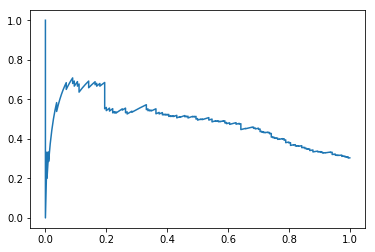

In [305]:
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
plt.figure;

num_columns = teacher_scaled.shape[1]
common_params = {'n_estimators':[100, 500, 1000], 
     'max_depth':range(2,100),
     'min_samples_leaf':range(2,100),
     'max_leaf_nodes':range(2,100),
#     'min_impurity_decrease':[0, .01, .1],
     'class_weight':[ 'balanced', None],
#      'oob_score':[True, False],
     'max_features':range(1,num_columns)
#      'min_samples_split':[2,4]
                }
#     ,
#     {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
# param_grid = [
#     {'n_estimators':[3,10,100]},#, 'max_features':[2,4,6,8]},
#     {'bootstrap':[True, False], 'n_estimators':[3,10,100, 1000]}#, 'max_features':[2,3,4]}
# ]
bootstrap_params = common_params.copy()
bootstrap_params['bootstrap'] = [True]
oob_params = common_params.copy()
oob_params['bootstrap'] = ['True']
oob_params['oob_score'] = [True, False]
param_grid = [bootstrap_params] 
cv = 10
forest_clf = RandomForestClassifier(random_state=108) #ExtraTreesClassifier(random_state=108)# 
# grid_search = GridSearchCV(forest_clf, param_grid, cv=cv, scoring='f1', n_jobs = -1, verbose=True)
grid_search = RandomizedSearchCV(forest_clf, param_distributions=common_params, cv=cv, scoring='f1', n_jobs = -1,  n_iter=20, verbose=True)
grid_search.fit(teacher_scaled.values, teacherlabels_scaled.ravel())
print grid_search.best_params_
# forest_clf = RandomForestClassifier(max_features=8, n_estimators=10, random_state=108)
# grid_search.estimator.fit(teacher_scaled.values, teacherlabels_scaled.ravel())
y_train_pred = cross_val_predict(grid_search.best_estimator_, teacher_scaled.values, teacherlabels_scaled.ravel(), cv=cv )

print confusion_matrix(teacherlabels_scaled.ravel(), y_train_pred)
print precision_score(teacherlabels_scaled.ravel(), y_train_pred)
print recall_score(teacherlabels_scaled.ravel(), y_train_pred)


y_scores = cross_val_predict(grid_search.best_estimator_, teacher_scaled.values, teacherlabels_scaled.ravel(), cv=cv, method='predict_proba' )
precisions, recalls, thresholds = precision_recall_curve(teacherlabels_scaled.ravel(), y_scores[:,1])
plt.close()
plt.plot(recalls, precisions)
plt.show()

In [308]:
test_predictions = grid_search.best_estimator_.predict(test_teacher_scaled.values)
test_predictions
print confusion_matrix(test_teacherlabels_scaled.ravel(), test_predictions)
print precision_score(test_teacherlabels_scaled.ravel(), test_predictions)
print recall_score(test_teacherlabels_scaled.ravel(), test_predictions)

[[88 25]
 [23 37]]
0.5967741935483871
0.6166666666666667


In [307]:
zip(grid_search.best_estimator_.feature_importances_, teacher_scaled.columns.tolist())

[(0.10715736624463044, u'pax_per_year'),
 (0.04226159256664758, u'New PaxStd'),
 (0.06154795234589892, u'New PaxSum'),
 (0.06345984687899943, u'New PaxMean'),
 (0.08157032742286656, u'Start DateStd'),
 (0.06456905005995277, u'Start DateMean'),
 (0.06820301263390967, u'NumCourses'),
 (0.05568223630198835, u'DaysAsTeacher'),
 (0.02416182806448479, 'AU2016'),
 (0.10351869863512274, 'AU2017'),
 (0.009748759949692305, 'called'),
 (0.08549127471788967, 'WithinLastFYHP'),
 (0.23262805417791677, 'dayssincelastcourse')]

In [ ]:
384+28+78+26

In [244]:
# grid_search.
grid_search.predict_proba(teacher_scaled.iloc[4,:].values.reshape(1,-1)),grid_search.best_estimator_.predict_proba(teacher_scaled.iloc[4,:].values.reshape(1,-1))

(array([[0.91289967, 0.08710033]]), array([[0.91289967, 0.08710033]]))

In [130]:
def delta_prob(row):
    rowcopy = row.copy()
#     print rowcopy['v4_called']
    prob_nocall = grid_search.predict_proba(rowcopy.values.reshape(1,-1))
    rowcopy['called'] = 1
    prob_call = grid_search.predict_proba(rowcopy.values.reshape(1,-1))
    delta = prob_call-prob_nocall
#     print prob_call, prob_nocall, rowcopy['v4_called']
    return asscalar(delta[:,[1]])

In [131]:
def abs_prob(row):
    prob = grid_search.predict_proba(row.values.reshape(1,-1))
    return asscalar(prob[:,[1]])

In [132]:
# print teachereval_scaled.iloc[1,:], teacher_scaled.iloc[1,:]
from numpy import asscalar
delta_evals = [delta_prob(teachereval_scaled.iloc[i,:]) for i in range(len(teachereval_scaled))]

In [133]:
delta_evals.sort(reverse=True)
set(delta_evals)

{-0.046875,
 -0.04687499999999997,
 -0.044642857142857206,
 -0.04464285714285715,
 -0.04464285714285712,
 -0.044642857142857095,
 -0.02901785714285715,
 -0.029017857142857123,
 -0.020512820512820537,
 -0.020512820512820523,
 -0.02051282051282051,
 -0.020512820512820495,
 -0.020512820512820468,
 -0.014285714285714318,
 -0.01428571428571429,
 -0.014285714285714284,
 -0.014285714285714277,
 -0.01428571428571427,
 -0.014285714285714263,
 -0.014285714285714249,
 -0.014285714285714235,
 -0.013392857142857206,
 -0.013392857142857095,
 -0.012500000000000039,
 -0.012500000000000025,
 -0.012500000000000011,
 -0.012500000000000004,
 -0.012499999999999997,
 -0.01249999999999999,
 -0.012499999999999983,
 -0.012499999999999956,
 -0.009523809523809545,
 -0.009523809523809532,
 -0.009523809523809525,
 -0.009523809523809518,
 -0.00952380952380951,
 -0.00801282051282054,
 -0.008012820512820526,
 -0.008012820512820512,
 -0.008012820512820505,
 -0.008012820512820498,
 -0.008012820512820484,
 -0.0071022727

In [ ]:
delta_prob(teachereval_scaled.iloc[1,:])

In [ ]:
v5calling_list = [{'TeacherId':teachereval_scaled_index[i],'Probability':abs_prob(teachereval_scaled.iloc[i,:])} for i in range(len(teachereval_scaled))]
# v5calling_df.to_csv('AU2018_prob_teacher.csv')

In [ ]:
DataFrame(v5calling_list).to_csv('AU2018_prob_teacher.csv')

In [ ]:
teachereval_scaled

In [ ]:
teacher_scaled.v4_called.sum(), teacherlabels_scaled.sum()

In [ ]:
called_announced = ((teacher_kpis['v4_Status']=='Received') & (teacher_kpis['Anandotsav2018']['<lambda>'])).sum()
called_not_announced = ((teacher_kpis['v4_Status']=='Received') & (~teacher_kpis['Anandotsav2018']['<lambda>'])).sum()
not_called_announced = ((teacher_kpis['v4_Status']!='Received') & (teacher_kpis['Anandotsav2018']['<lambda>'])).sum()
not_called_not_announced = ((teacher_kpis['v4_Status']!='Received') & (~teacher_kpis['Anandotsav2018']['<lambda>'])).sum()
contingency_table = np.array([[called_announced, called_not_announced],[not_called_announced, not_called_not_announced]])
print contingency_table

In [ ]:
56.0/(56+160), 1811.0/(1811+12847)

In [ ]:
called_announced = ((teacher_mldata['called']==1) & (teacher_mldata['AU2018'])).sum()
called_not_announced = ((teacher_mldata['called']==1) & (~teacher_mldata['AU2018'])).sum()
not_called_announced = ((teacher_mldata['called']!=1) & (teacher_mldata['AU2018'])).sum()
not_called_not_announced = ((teacher_mldata['called']!=1) & (~teacher_mldata['AU2018'])).sum()
contingency_table = np.array([[called_announced, called_not_announced],[not_called_announced, not_called_not_announced]])
print contingency_table

In [ ]:
from scipy.stats import chi2_contingency
g, p, dof, expctd = chi2_contingency(contingency_table)
print g, p

In [ ]:
130.0/(130+246), 120.0/(120+367)

In [ ]:
(130+246)*.24, 

In [ ]:
print thresholds.shape, recalls.shape, precisions.shape
plt.plot(thresholds, recalls[:-1], 'b--', label='Recall')
plt.plot(thresholds, precisions[:-1], 'g-', label='Precision')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.show()

In [ ]:
y_train_pred80 = (y_scores[:,1]>.35)
print confusion_matrix(teacherlabels_scaled.ravel(), y_train_pred80)
print precision_score(teacherlabels_scaled.ravel(), y_train_pred80)
print recall_score(teacherlabels_scaled.ravel(), y_train_pred80)

In [ ]:
grid_search.estimator.

In [ ]:
teacherlabels_scaled.shape, teacher_scaled.shape

In [ ]:
teacher_mldata.v4_called

In [ ]:
# scaled.pax_per_year.min(), scaled.pax_per_year.max(), scaled['Start DateStd'].min(), scaled['Start DateStd'].max()
teacher_scaled.describe()

In [ ]:
scaled

In [ ]:
pd.concat([scaled.AU2018, strat_train_set.AU2018.reset_index()], axis=1)

In [ ]:
teacher_mldata.shape

In [ ]:
import sys
sys.float_info

In [ ]:
received_v4 = v4_calling[v4_calling.Status=='Received'].index
teacher_kpis[teacher_kpis.index.to_series().isin(received_v4)]

In [ ]:
print teacher_kpis['v4_Status'].count(), teacher_kpis['Will Teach Anand Utsav'].count(), teacher_kpis.shape
v4_calling.columns

In [ ]:
v4_calling[(~v4_calling['Will Teach Anand Utsav'].isnull()) & (v4_calling['Status'].isnull())]

In [ ]:
v4_calling['Will Teach Anand Utsav'].value_counts()

In [ ]:
for caller in ['aditya', 'sajini', 'resham', 'aman']:
    binned = caller+'_binned'
    eval_binned = eval(binned)
    eval_binned.groupby(by=eval_binned).apply(lambda s: s.sample(frac=1, replace=False)).to_csv(binned+'.csv')

In [ ]:
resham_binned[~resham_binned.isnull()]

In [ ]:
df_sent_to_aolsc = DataFrame.from_csv('SupportCenter2017AU/SentToAoLSC.csv')
df_course_announced = DataFrame.from_csv('SupportCenter2017AU/CourseAnnounced.csv')
df_will_announce_soon = DataFrame.from_csv('SupportCenter2017AU/WillAnnounceSoon.csv')
df_will_not_announce = DataFrame.from_csv('SupportCenter2017AU/WillNotAnnounce.csv')

In [ ]:
notin_will_announce_soon=df_will_announce_soon[~df_will_announce_soon.index.to_series().isin(test1015['T.CODE'])]
notin_course_announced=df_course_announced[~df_course_announced.index.to_series().isin(test1015['T.CODE'])]
notin_will_not_announce=df_will_not_announce[~df_will_not_announce.index.to_series().isin(test1015['T.CODE'])]

In [ ]:
notin1015=pd.concat([notin_course_announced, notin_will_announce_soon, notin_will_not_announce]).sort_index()

In [ ]:
notin1015

In [ ]:
test5038=pd.read_clipboard()
test5038

In [ ]:
all(df_course_announced.index.to_series().isin(test5038['T.CODE']))

In [ ]:
df_support_center = pd.concat([df_course_announced, df_will_announce_soon, df_will_not_announce])
df_support_center

In [ ]:
'AP0247' in df_support_center.index.to_series()

In [ ]:
df_sent_to_aolsc.shape, df_will_announce_soon.shape, df_will_not_announce.shape, df_course_announced.shape

In [ ]:
hp_bool = teacherdb['Course Taught'].apply(lambda x:any(course in happiness_coursetypes for course in x.split(','))  if not (isinstance(x,float) or isinstance(x, int)) else np.nan)
sum(hp_bool.dropna()), len(hp_bool)

In [ ]:
173+77+159

In [ ]:
80+121+44 +43+31+16+ 36+21+17

In [ ]:
568+266+181

In [ ]:
test1015=pd.read_clipboard()

In [ ]:
def cum_delay_plot(start_date, end_date):
    masterdf_newer=masterdf[(masterdf['Start Date']>start_date) & (masterdf['Start Date']<=end_date)]
    from collections import OrderedDict
    cum_delay= OrderedDict()
    quantrange=np.logspace(-1,0,50, endpoint=False) #np.arange(0.1,1.0,.1)
    for quant in quantrange:
        cum_delay[str(quant)]=(masterdf_newer['CRF Submitted Date']- masterdf_newer['Start Date']).quantile(quant)/ np.timedelta64(1, 'D')

    plt.plot(cum_delay.values(), quantrange*100)
#     plt.ylim[0,105]
#     plt.yticks(np.arange(0,100,20))

    plt.xlabel('Days Since Course Start')
    plt.ylabel('% CRF Submitted')
    plt.axhline(80, color='r', linestyle='dotted')
    plt.axhline(90, color='k', linestyle='dotted')
    plt.axvline(np.interp(80,quantrange*100,cum_delay.values()), color='r', linestyle='dotted')
    plt.axvline(np.interp(90,quantrange*100,cum_delay.values()), color='k', linestyle='dotted')
    plt.title('Cumulative Delay: {0} - {1}'.format(start_date.strftime("%d %b '%y"),end_date.strftime("%d %b '%y")))
    fig_format='png'
    plt.savefig('CumDelay{0}_{1}'.format(start_date.strftime("%d%b%y"),end_date.strftime("%d%b%y")+'.'+fig_format, dpi=200), format=fig_format)
    plt.show()
    return cum_delay, quantrange
    

In [ ]:
start_date=date(2012,1,1)
end_date=date(2014,1,1)
cum_delay, quantrange=cum_delay_plot(start_date , end_date)

In [ ]:
# plt.yticks[np.arange(1,100,20)]
cum_delay

In [ ]:
start_date = date(2012,6,1)
end_date = date(2018,1,1)
startdates = masterdf['Start Date']
cut_out = pd.cut(startdates[(startdates>start_date) & (startdates<=end_date)],25)
delay_quant50=[]#OrderedDict()
delay_quant80=[]#OrderedDict()
delay_quant90=[]#OrderedDict()
# delay_quant50=OrderedDict()
for category in cut_out.cat.categories:
    masterdf_newer = masterdf[(startdates>start_date) & (startdates<=end_date)][cut_out==category]
    delays=(masterdf_newer['CRF Submitted Date']- masterdf_newer['Start Date']).quantile(.5)/ np.timedelta64(1, 'D')
    delay_quant50.append(delays)
    
    delays=(masterdf_newer['CRF Submitted Date']- masterdf_newer['Start Date']).quantile(.8)/ np.timedelta64(1, 'D')
    delay_quant80.append(delays)
    
    delays=(masterdf_newer['CRF Submitted Date']- masterdf_newer['Start Date']).quantile(.9)/ np.timedelta64(1, 'D')
    delay_quant90.append(delays)

plt.plot([category.mid for category in cut_out.cat.categories], delay_quant50, label='50% Data Received')
plt.plot([category.mid for category in cut_out.cat.categories], delay_quant80, label='80% Data Received')
plt.plot([category.mid for category in cut_out.cat.categories], delay_quant90, label='90% Data Received')
plt.legend()
plt.ylabel('Number of Days')
plt.savefig('CRFSubmissionTrend',format='png', dpi=200)
plt.show()

In [ ]:
start_date = date(2016,1,1)
end_date = date(2018,1,1)
temp_df=masterdf[(startdates>start_date) & (startdates<=end_date) & (not masterdf['Anandotsav2017'])]
plt.scatter(temp_df['New Pax'],(temp_df['CRF Submitted Date']-temp_df['Start Date'])/ np.timedelta64(1, 'D'),alpha=.5)
plt.show()

In [ ]:
[category.mid for category in cut_out.cat.categories]

In [ ]:
def get_num_courses(Id):
#     x=[rowdicts for (ix, rowdicts) in masterdf['teacher_rowdicts'].iteritems()]
#     print x
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~NOTE: masterdf2=masterdf.dropna(subset=['Teachers'])
    boolId = masterdf2['teacher_rowdicts'].apply(lambda x:any([rowdict['Id']==Id for rowdict in x]))
    num_courses=masterdf2[boolId].count()['ID']
                                                       
#     num_courses  = sum([any([rowdict['Id']==Id for rowdict in rowdicts])  
#                for (ix, rowdicts) in masterdf2['teacher_rowdicts'].iteritems()]) #.applymap(lambda x:any([rowdict['Id']==Id for rowdict in x]))
    return num_courses

num_courses=teacher_df.Id.map(get_num_courses)

teacher_df.shape

%timeit get_num_courses('PJ0230')

%timeit get_num_courses('PJ0230')

len(teacher_dictlist), len(teacher_dictlist_hp)

masterdf.shape

masterdf_uniqteach

ix = masterdf_uniqteach['teacher_rowdicts'][5].index.unique()

masterdf2.loc[ix,'teacher_id'] = [rowdict['Id'] for rowdict in masterdf2['teacher_rowdicts'][5]]

[rowdict['Id'] for rowdict in masterdf2['teacher_rowdicts'][5]]

masterdf_uniqteach.loc[ix,'Teachers']

masterdf_uniqteach.loc[:,'TeacherId'] = np.nan
masterdf_uniqteach.columns

masterdf_uniqteach.loc[ix,'TeacherId']=['CD0010', 'KR0105']

def insert_unique_teacherId(Index, row):
#     print row.index
#     return index
    idlist = [rowdict['Id'] for rowdict in row['teacher_rowdicts']]
    ix = masterdf_uniqteach['teacher_rowdicts'][Index].index.unique()
    masterdf_uniqteach.loc[ix,'TeacherId']=idlist

[insert_unique_teacherId(index, row) for (index, row) in masterdf2.iterrows()]

%timeit insert_unique_teacherId(5,masterdf2.iloc[5])

287369*1.71/3600

masterdf_uniqteach.loc[:,'TeacherId']=[teacher['Id'] for teacher in teacher_dictlist]

masterdf_uniqteach

In [ ]:
days_from_start = masterdf['Start Date'].apply(lambda x:((date.today()-x.date())))
days_from_start = days_from_start.astype('timedelta64[D]').astype('int')

In [ ]:
((days_from_start<365) & (masterdf['Course Type'].isin(happiness_coursetypes))).sum()

In [ ]:
days_from_start.size

In [ ]:
masterdf[(days_from_start<365) & (masterdf['Course Type'].isin(happiness_coursetypes))]['New Pax'].sum()

In [ ]:
from sklearn.pipeline import Pipeline

In [285]:
len(allcolumns)

13